In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Clock-D19-EPM/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
c19_epm_file = DATA_PATH + "C19_EPM_Data.pkl"
proj_file = PROJECT_PATH + "c19_epm_projection.csv"
bxcx_proj_file = PROJECT_PATH + "bxcx_c19_epm_projection.csv"

mean_file = PROJECT_PATH + "c19_epm_mean_scores.csv"
bxcx_mean_file = PROJECT_PATH + "bxcx_c19_epm_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_WEIGHT = [10,1,1]


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
df_full = pd.read_csv(proj_file)
df_in_task = df_full[df_full['in-task']==1].copy()
df_clck = df_in_task[df_in_task["condition"]=="CLOCK"].copy()
df_wt = df_in_task[df_in_task["condition"]=="WT"].copy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in remainder


[0.11415219 0.09397108 0.09728188] [0.01149429 0.00918604 0.00839056]
[0.09187123 0.08440779 0.08712622] [0.01078783 0.00807875 0.00767512]


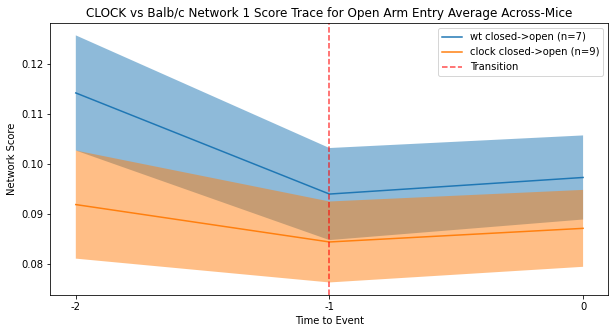

[0.16498187 0.13862629 0.15925937] [0.01395933 0.01888504 0.01726087]
[0.13620558 0.12517064 0.12989396] [0.01184088 0.0081365  0.00992412]


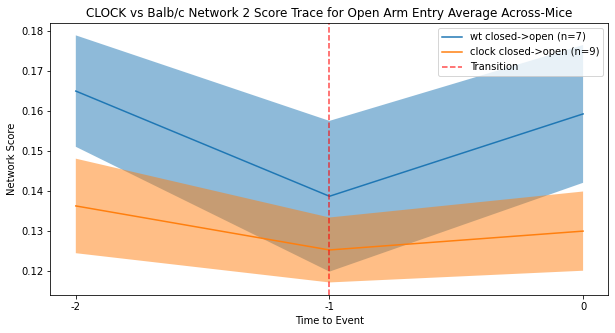

[0.03905928 0.03700172 0.03990251] [0.00639981 0.00679185 0.00680165]
[0.06517865 0.06394031 0.0619855 ] [0.00638735 0.00689385 0.008285  ]


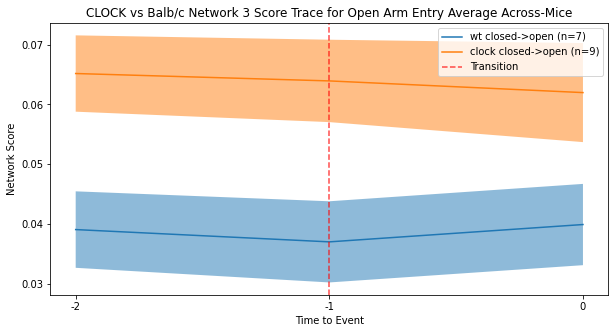

In [4]:
n_windows_before = 2
n_windows_after = 1

clock_n1_mouse_means = []
clock_n2_mouse_means = []
clock_n3_mouse_means = []
clock_mouse_id = []
clock_n_segs = []

wt_n1_mouse_means = []
wt_n2_mouse_means = []
wt_n3_mouse_means = []
wt_mouse_id = []
wt_n_segs = []

for mouse in np.unique(df_in_task.mouse):
    
    mouse_mask = df_in_task.mouse==mouse
    mouse_roi = 1-df_in_task[mouse_mask==1]["roi"].values%2
    isClock = df_in_task[mouse_mask==1]["condition"].values[0]=="CLOCK"

    n1_s = df_in_task[mouse_mask==1]["net 1 scores"].values
    n2_s = df_in_task[mouse_mask==1]["net 2 scores"].values
    n3_s = df_in_task[mouse_mask==1]["net 3 scores"].values
    
    clock_seg_idxs = []
    wt_seg_idxs = []
    
        
    for idx, roi in enumerate(mouse_roi):
        
        
        if idx > n_windows_before and idx < (len(mouse_roi) - n_windows_after):
            
            #Get CA to OA
            seg_start = idx - n_windows_before
            seg_end = idx + n_windows_after
            
            isTransition = mouse_roi[idx]==1 and mouse_roi[idx-1]==0

            beforeStable = np.sum(mouse_roi[seg_start:idx])==0
            afterStable = np.sum(mouse_roi[idx:seg_end])==n_windows_after
            isStable = np.logical_and(beforeStable,afterStable)
            
            if isTransition and isStable:
                
                if isClock:
                    clock_seg_idxs.append((seg_start,seg_end))
                else:
                    wt_seg_idxs.append((seg_start,seg_end))
            
              
    #save ca to oa segments
    if len(clock_seg_idxs) > 0:
        clock_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in clock_seg_idxs]),
                          axis=0)
        clock_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in clock_seg_idxs]),
                          axis=0)
        clock_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in clock_seg_idxs]),
                          axis=0)

        clock_n1_mouse_means.append(clock_n1_segs_mean)
        clock_n2_mouse_means.append(clock_n2_segs_mean)
        clock_n3_mouse_means.append(clock_n3_segs_mean)
        clock_mouse_id.append(mouse)
        clock_n_segs.append(len(clock_seg_idxs))
      
    #save oa to ca segments
    if len(wt_seg_idxs) > 0:
        wt_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in wt_seg_idxs]),
                          axis=0)
        wt_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in wt_seg_idxs]),
                          axis=0)
        wt_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in wt_seg_idxs]),
                          axis=0)

        wt_n1_mouse_means.append(wt_n1_segs_mean)
        wt_n2_mouse_means.append(wt_n2_segs_mean)
        wt_n3_mouse_means.append(wt_n3_segs_mean)
        wt_mouse_id.append(mouse)
        wt_n_segs.append(len(wt_seg_idxs))
    
clock_n1_mouse_means = np.array(clock_n1_mouse_means)
clock_n2_mouse_means = np.array(clock_n2_mouse_means)
clock_n3_mouse_means = np.array(clock_n3_mouse_means)
clock_mouse_id = np.array(clock_mouse_id)
clock_n_segs = np.array(clock_n_segs)

wt_n1_mouse_means = np.array(wt_n1_mouse_means)
wt_n2_mouse_means = np.array(wt_n2_mouse_means)
wt_n3_mouse_means = np.array(wt_n3_mouse_means)
wt_mouse_id = np.array(wt_mouse_id)
wt_n_segs = np.array(wt_n_segs)

clock_scores_list = [clock_n1_mouse_means, clock_n2_mouse_means, clock_n3_mouse_means]
wt_scores_list = [wt_n1_mouse_means, wt_n2_mouse_means, wt_n3_mouse_means]

for net in range(3):
    
    plt.figure(figsize=(10,5))
    mean = np.mean(wt_scores_list[net],axis=0)
    stderr = np.std(wt_scores_list[net],axis=0) / np.sqrt(wt_scores_list[net].shape[0])
    print(mean,stderr)
    plt.plot(mean, label="wt closed->open (n={})".format(len(wt_mouse_id)))
    #plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(clock_scores_list[net],axis=0)
    stderr = np.std(clock_scores_list[net],axis=0) / np.sqrt(clock_scores_list[net].shape[0])
    print(mean,stderr)

    plt.plot(mean, label="clock closed->open (n={})".format(len(clock_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Transition")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Event")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)
    #plt.ylim([3.2,5.5])
    plt.legend()
    plt.title("CLOCK vs Balb/c Network {} Score Trace for Open Arm Entry Average Across-Mice".format(net+1))
    plt.show()
    
    clck_saveMat = np.hstack([clock_mouse_id.reshape(-1,1),
                             np.array(["clck" for _ in clock_mouse_id]).reshape(-1,1),
                             np.array(clock_scores_list[net])]).astype(object)
    wt_saveMat = np.hstack([wt_mouse_id.reshape(-1,1),
                           np.array(["wt" for _ in wt_mouse_id]).reshape(-1,1),
                           np.array(wt_scores_list[net])]).astype(object)
    saveMat = np.vstack([clck_saveMat,wt_saveMat])
    temp_df = pd.DataFrame(saveMat,columns=["mouse","geno","-2","-1","0"])
    temp_df.to_csv(PROJECT_PATH + "Clock_vs_WT_EPM_closed_to_open_net_{}.csv".format(net))

In [14]:
temp_df

,mouse,geno,-2,-1,0
0,Mouse0912,clck,0.088535814,0.083417038875,0.074086813
1,Mouse0913,clck,0.047998005071428575,0.05930489199999999,0.05927447314285715
2,Mouse2401,clck,0.06847500800000002,0.081260947,0.0653918101
3,Mouse3881,clck,0.09833237,0.093268598,0.09489738866666668
4,Mouse3882,clck,0.06814485675000001,0.07965101150000001,0.0647078425
5,Mouse3883,clck,0.06637343823076923,0.06446268776923078,0.06471006976923077
6,Mouse69841,clck,0.05824927966666666,0.037206911333333335,0.0073832954
7,Mouse69872,clck,0.02941747171111111,0.03478523566666667,0.03812392392222222
8,Mouse69873,clck,0.06108157166666667,0.04210546066666667,0.08929385166666666
9,Mouse0914,wt,0.0560348605,0.05400352025,0.054876893375


Mouse0912 206 506
Mouse0913 204 504
Mouse2401 344 644
Mouse3881 365 665
Mouse3882 278 578
Mouse3883 139 439
Mouse69841 381 681
Mouse69872 322 622
Mouse69873 338 638


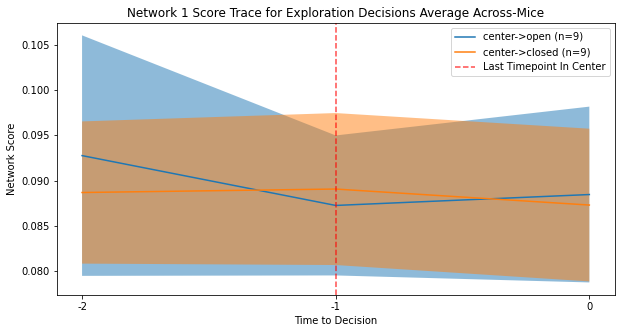

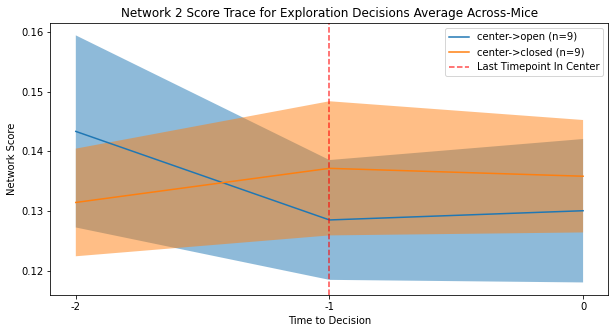

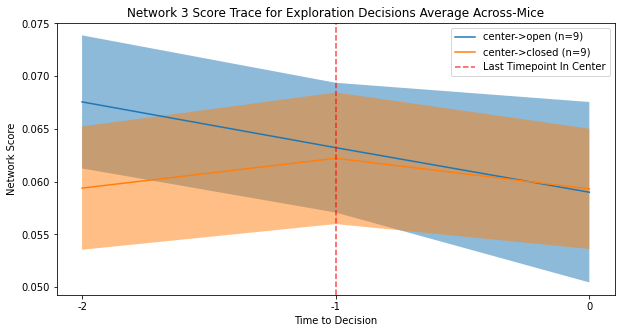

In [23]:
# Define window sizes before and after a specific point
n_windows_before = 2
n_windows_after = 1

# Initialize lists to store means and other data for different conditions and mice
clck_c2o_n1_mouse_means = []
clck_c2o_n2_mouse_means = []
clck_c2o_n3_mouse_means = []
clck_c2o_time_ids = []
clck_c2o_mouse_id = []
clck_c2o_n_segs = []

clck_c2cl_n1_mouse_means = []
clck_c2cl_n2_mouse_means = []
clck_c2cl_n3_mouse_means = []
clck_c2cl_time_ids = []
clck_c2cl_mouse_id = []
clck_c2cl_n_segs = []

# Iterate over unique mice in the dataframe
for mouse in np.unique(df_clck.mouse):

    # Create a mask for the current mouse
    mouse_mask = df_clck.mouse==mouse
    # Filter out NaN values in the ROI column
    nan_filter = df_clck.roi > 0
    mask = np.logical_and(mouse_mask,nan_filter)
    
    mouse_time = df_clck[mask==1]["time"].values
    task_start_time = np.min(mouse_time)
    task_end_time = task_start_time + 300
    time_mask = df_clck.time < task_end_time
    print(mouse,task_start_time,task_end_time)
    mask = np.logical_and(mask,time_mask)
    
    # Define masks for different conditions (CA, OA)
    oa_mask = np.logical_or(df_clck[mask==1]["roi"].values==2,
                            df_clck[mask==1]["roi"].values==4)

    ca_mask = np.logical_or(df_clck[mask==1]["roi"].values==1,
                            df_clck[mask==1]["roi"].values==3)
    
    # Extract relevant data for the current mouse and condition
    mouse_roi = df_clck[mask==1]["roi"].values
    mouse_time = df_clck[mask==1]["time"].values
    n1_s = df_clck[mask==1]["net 1 scores"].values
    n2_s = df_clck[mask==1]["net 2 scores"].values
    n3_s = df_clck[mask==1]["net 3 scores"].values
    
    # Initialize lists to store segment indexes for different conditions
    c2o_seg_idxs = []
    c2cl_seg_idxs = []

    # Iterate over ROI indexes and values
    for idx, roi in enumerate(mouse_roi):
        
        # Check if the current index is within the valid range
        if idx > n_windows_before and idx < (len(mouse_roi) - n_windows_after):
            
            # Get segment start and end points for CA to OA transition
            seg_start = idx - n_windows_before
            seg_end = idx + n_windows_after
            
            # Check for CA to OA transition conditions
            c2o_isTransition = oa_mask[idx]==1 and mouse_roi[idx-1]==5 and oa_mask[idx-2] == 0
            
            c2o_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2o_afterStable = np.sum(oa_mask[idx:seg_end])==n_windows_after
            c2o_isStable = np.logical_and(c2o_beforeStable,c2o_afterStable)
            
            c2o_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            
            if c2o_isTransition and c2o_isStable and c2o_isCont:
                c2o_seg_idxs.append((seg_start,seg_end))
                
            # Get segment start and end points for OA to CA transition
            c2cl_isTransition = mouse_roi[idx-1]==5 and oa_mask[idx-2]==0 and ca_mask[idx] == 1
            c2cl_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2cl_afterStable = np.sum(ca_mask[idx:seg_end])==n_windows_after
            c2cl_isStable = np.logical_and(c2cl_beforeStable,c2cl_afterStable)
            c2cl_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))

            if c2cl_isTransition and c2cl_isStable:
                c2cl_seg_idxs.append((seg_start,seg_end))
              
    # Save CA to OA segments if found
    if len(c2o_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2o_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2o_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        clck_c2o_n1_mouse_means.append(c2o_n1_segs_mean)
        clck_c2o_n2_mouse_means.append(c2o_n2_segs_mean)
        clck_c2o_n3_mouse_means.append(c2o_n3_segs_mean)
        clck_c2o_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2o_seg_idxs])
        clck_c2o_mouse_id.append(mouse)
        clck_c2o_n_segs.append(len(c2o_seg_idxs))
      
    # Save OA to CA segments if found
    if len(c2cl_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2cl_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        clck_c2cl_n1_mouse_means.append(c2cl_n1_segs_mean)
        clck_c2cl_n2_mouse_means.append(c2cl_n2_segs_mean)
        clck_c2cl_n3_mouse_means.append(c2cl_n3_segs_mean)
        clck_c2cl_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2cl_seg_idxs])
        clck_c2cl_mouse_id.append(mouse)
        clck_c2cl_n_segs.append(len(c2cl_seg_idxs))
    
# Convert lists to numpy arrays for easier manipulation
clck_c2o_n1_mouse_means = np.array(clck_c2o_n1_mouse_means)
clck_c2o_n2_mouse_means = np.array(clck_c2o_n2_mouse_means)
clck_c2o_n3_mouse_means = np.array(clck_c2o_n3_mouse_means)
clck_c2o_mouse_id = np.array(clck_c2o_mouse_id)
clck_c2o_time_ids = np.array(clck_c2o_time_ids,dtype=object)
clck_c2o_n_segs = np.array(clck_c2o_n_segs)

clck_c2cl_n1_mouse_means = np.array(clck_c2cl_n1_mouse_means)
clck_c2cl_n2_mouse_means = np.array(clck_c2cl_n2_mouse_means)
clck_c2cl_n3_mouse_means = np.array(clck_c2cl_n3_mouse_means)
clck_c2cl_mouse_id = np.array(clck_c2cl_mouse_id)
clck_c2cl_time_ids = np.array(clck_c2cl_time_ids,dtype=object)
clck_c2cl_n_segs = np.array(clck_c2cl_n_segs)

# Organize scores lists for CA to OA and OA to CA transitions
clck_c2o_scores_list = [clck_c2o_n1_mouse_means, clck_c2o_n2_mouse_means, clck_c2o_n3_mouse_means]
clck_c2cl_scores_list = [clck_c2cl_n1_mouse_means, clck_c2cl_n2_mouse_means, clck_c2cl_n3_mouse_means]

for net in range(3):
    
    mean = np.mean(clck_c2o_scores_list[net],axis=0)
    stderr = np.std(clck_c2o_scores_list[net],axis=0) / np.sqrt(clck_c2o_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="center->open (n={})".format(len(clck_c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(clck_c2cl_scores_list[net],axis=0)
    stderr = np.std(clck_c2cl_scores_list[net],axis=0) / np.sqrt(clck_c2cl_scores_list[net].shape[0])
    
    plt.plot(mean, label="center->closed (n={})".format(len(clck_c2cl_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Last Timepoint In Center")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Decision")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)

    plt.legend()
    plt.title("Network {} Score Trace for Exploration Decisions Average Across-Mice".format(net+1))
    plt.show()
    
    clck_saveMat = np.hstack([clck_c2o_mouse_id.reshape(-1,1),
                             np.array(["clck" for _ in clck_c2o_mouse_id]).reshape(-1,1),
                            np.array(["center->open" for _ in clck_c2o_mouse_id]).reshape(-1,1),
                             np.array(clck_c2o_scores_list[net])]).astype(object)
    wt_saveMat = np.hstack([clck_c2cl_mouse_id.reshape(-1,1),
                           np.array(["clck" for _ in clck_c2cl_mouse_id]).reshape(-1,1),
                            np.array(["center->closed" for _ in clck_c2cl_mouse_id]).reshape(-1,1),
                           np.array(clck_c2cl_scores_list[net])]).astype(object)
    
    saveMat = np.vstack([clck_saveMat,wt_saveMat])
    temp_df = pd.DataFrame(saveMat,columns=["mouse","geno","decision","-2","-1","0"])
    temp_df.to_csv(PROJECT_PATH + "Clock_center_to_open_vs_center_to_closed_net_{}.csv".format(net))

Mouse0912 206 506
Mouse0913 204 504
Mouse2401 344 644
Mouse3881 365 665
Mouse3882 278 578
Mouse3883 139 439
Mouse69841 381 681
Mouse69872 322 622
Mouse69873 338 638


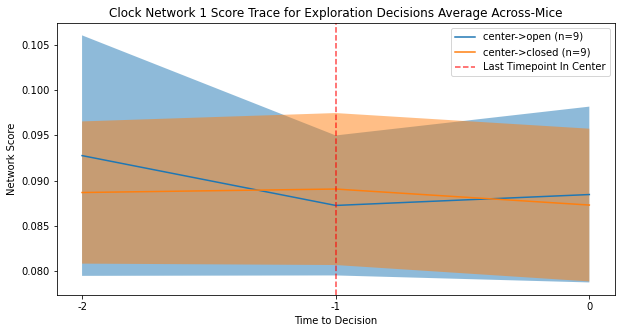

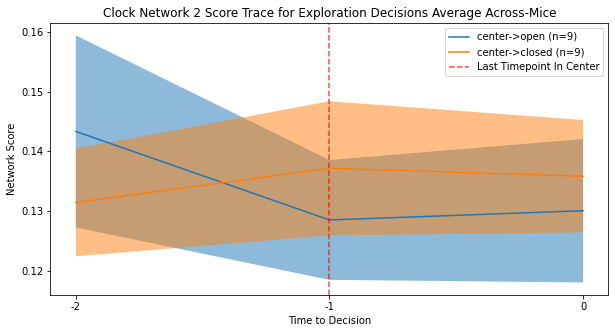

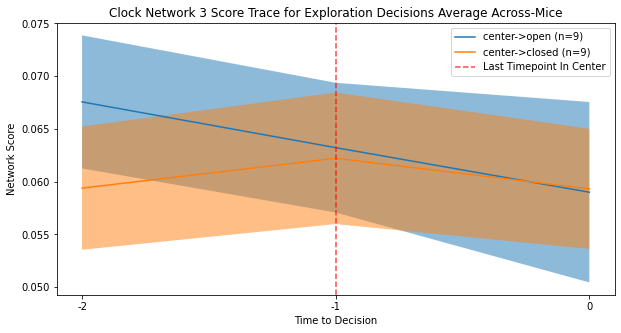

In [29]:
# Define window sizes before and after a specific point
n_windows_before = 2
n_windows_after = 1

# Initialize lists to store means and other data for different conditions and mice
clck_c2o_n1_mouse_means = []
clck_c2o_n2_mouse_means = []
clck_c2o_n3_mouse_means = []
clck_c2o_time_ids = []
clck_c2o_mouse_id = []
clck_c2o_n_segs = []

clck_c2cl_n1_mouse_means = []
clck_c2cl_n2_mouse_means = []
clck_c2cl_n3_mouse_means = []
clck_c2cl_time_ids = []
clck_c2cl_mouse_id = []
clck_c2cl_n_segs = []

# Iterate over unique mice in the dataframe
for mouse in np.unique(df_clck.mouse):

    # Create a mask for the current mouse
    mouse_mask = df_clck.mouse==mouse
    # Filter out NaN values in the ROI column
    nan_filter = df_clck.roi > 0
    mask = np.logical_and(mouse_mask,nan_filter)
    
    mouse_time = df_clck[mask==1]["time"].values
    task_start_time = np.min(mouse_time)
    task_end_time = task_start_time + 300
    time_mask = df_clck.time < task_end_time
    print(mouse,task_start_time,task_end_time)
    mask = np.logical_and(mask,time_mask)
    
    # Define masks for different conditions (CA, OA)
    oa_mask = np.logical_or(df_clck[mask==1]["roi"].values==2,
                            df_clck[mask==1]["roi"].values==4)

    ca_mask = np.logical_or(df_clck[mask==1]["roi"].values==1,
                            df_clck[mask==1]["roi"].values==3)
    
    # Extract relevant data for the current mouse and condition
    mouse_roi = df_clck[mask==1]["roi"].values
    mouse_time = df_clck[mask==1]["time"].values
    n1_s = df_clck[mask==1]["net 1 scores"].values
    n2_s = df_clck[mask==1]["net 2 scores"].values
    n3_s = df_clck[mask==1]["net 3 scores"].values
    
    # Initialize lists to store segment indexes for different conditions
    c2o_seg_idxs = []
    c2cl_seg_idxs = []

    # Iterate over ROI indexes and values
    for idx, roi in enumerate(mouse_roi):
        
        # Check if the current index is within the valid range
        if idx > n_windows_before and idx < (len(mouse_roi) - n_windows_after):
            
            # Get segment start and end points for CA to OA transition
            seg_start = idx - n_windows_before
            seg_end = idx + n_windows_after
            
            # Check for CA to OA transition conditions
            c2o_isTransition = oa_mask[idx]==1 and mouse_roi[idx-1]==5 and oa_mask[idx-2] == 0
            
            c2o_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2o_afterStable = np.sum(oa_mask[idx:seg_end])==n_windows_after
            c2o_isStable = np.logical_and(c2o_beforeStable,c2o_afterStable)
            
            c2o_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            
            if c2o_isTransition and c2o_isStable and c2o_isCont:
                c2o_seg_idxs.append((seg_start,seg_end))
                
            # Get segment start and end points for OA to CA transition
            c2cl_isTransition = mouse_roi[idx-1]==5 and oa_mask[idx-2]==0 and ca_mask[idx] == 1
            c2cl_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2cl_afterStable = np.sum(ca_mask[idx:seg_end])==n_windows_after
            c2cl_isStable = np.logical_and(c2cl_beforeStable,c2cl_afterStable)
            c2cl_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))

            if c2cl_isTransition and c2cl_isStable:
                c2cl_seg_idxs.append((seg_start,seg_end))
              
    # Save CA to OA segments if found
    if len(c2o_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2o_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2o_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        clck_c2o_n1_mouse_means.append(c2o_n1_segs_mean)
        clck_c2o_n2_mouse_means.append(c2o_n2_segs_mean)
        clck_c2o_n3_mouse_means.append(c2o_n3_segs_mean)
        clck_c2o_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2o_seg_idxs])
        clck_c2o_mouse_id.append(mouse)
        clck_c2o_n_segs.append(len(c2o_seg_idxs))
      
    # Save OA to CA segments if found
    if len(c2cl_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2cl_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        clck_c2cl_n1_mouse_means.append(c2cl_n1_segs_mean)
        clck_c2cl_n2_mouse_means.append(c2cl_n2_segs_mean)
        clck_c2cl_n3_mouse_means.append(c2cl_n3_segs_mean)
        clck_c2cl_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2cl_seg_idxs])
        clck_c2cl_mouse_id.append(mouse)
        clck_c2cl_n_segs.append(len(c2cl_seg_idxs))
    
# Convert lists to numpy arrays for easier manipulation
clck_c2o_n1_mouse_means = np.array(clck_c2o_n1_mouse_means)
clck_c2o_n2_mouse_means = np.array(clck_c2o_n2_mouse_means)
clck_c2o_n3_mouse_means = np.array(clck_c2o_n3_mouse_means)
clck_c2o_mouse_id = np.array(clck_c2o_mouse_id)
clck_c2o_time_ids = np.array(clck_c2o_time_ids,dtype=object)
clck_c2o_n_segs = np.array(clck_c2o_n_segs)

clck_c2cl_n1_mouse_means = np.array(clck_c2cl_n1_mouse_means)
clck_c2cl_n2_mouse_means = np.array(clck_c2cl_n2_mouse_means)
clck_c2cl_n3_mouse_means = np.array(clck_c2cl_n3_mouse_means)
clck_c2cl_mouse_id = np.array(clck_c2cl_mouse_id)
clck_c2cl_time_ids = np.array(clck_c2cl_time_ids,dtype=object)
clck_c2cl_n_segs = np.array(clck_c2cl_n_segs)

# Organize scores lists for CA to OA and OA to CA transitions
clck_c2o_scores_list = [clck_c2o_n1_mouse_means, clck_c2o_n2_mouse_means, clck_c2o_n3_mouse_means]
clck_c2cl_scores_list = [clck_c2cl_n1_mouse_means, clck_c2cl_n2_mouse_means, clck_c2cl_n3_mouse_means]

for net in range(3):
    
    mean = np.mean(clck_c2o_scores_list[net],axis=0)
    stderr = np.std(clck_c2o_scores_list[net],axis=0) / np.sqrt(clck_c2o_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="center->open (n={})".format(len(clck_c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(clck_c2cl_scores_list[net],axis=0)
    stderr = np.std(clck_c2cl_scores_list[net],axis=0) / np.sqrt(clck_c2cl_scores_list[net].shape[0])
    
    plt.plot(mean, label="center->closed (n={})".format(len(clck_c2cl_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Last Timepoint In Center")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Decision")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)

    plt.legend()
    plt.title("Clock Network {} Score Trace for Exploration Decisions Average Across-Mice".format(net+1))
    plt.show()
    
    clck_saveMat = np.hstack([clck_c2o_mouse_id.reshape(-1,1),
                             np.array(["clck" for _ in clck_c2o_mouse_id]).reshape(-1,1),
                            np.array(["center->open" for _ in clck_c2o_mouse_id]).reshape(-1,1),
                             np.array(clck_c2o_scores_list[net])]).astype(object)
    wt_saveMat = np.hstack([clck_c2cl_mouse_id.reshape(-1,1),
                           np.array(["clck" for _ in clck_c2cl_mouse_id]).reshape(-1,1),
                            np.array(["center->closed" for _ in clck_c2cl_mouse_id]).reshape(-1,1),
                           np.array(clck_c2cl_scores_list[net])]).astype(object)
    
    saveMat = np.vstack([clck_saveMat,wt_saveMat])
    temp_df = pd.DataFrame(saveMat,columns=["mouse","geno","decision","-2","-1","0"])
    temp_df.to_csv(PROJECT_PATH + "Clock_center_to_open_vs_center_to_closed_net_{}.csv".format(net))

Mouse0911 239 539
Mouse0914 203 503
Mouse2402 195 495
Mouse2403 195 495
Mouse30391 349 649
Mouse30392 330 630
Mouse69861 323 623
Mouse69862 330 630


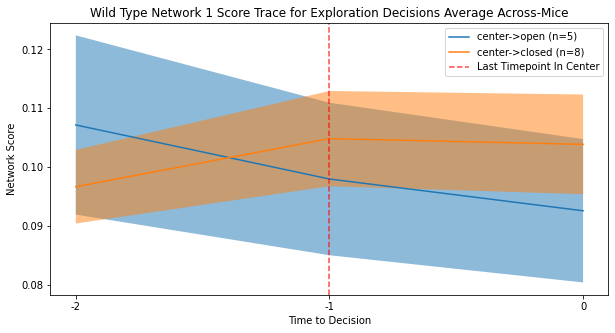

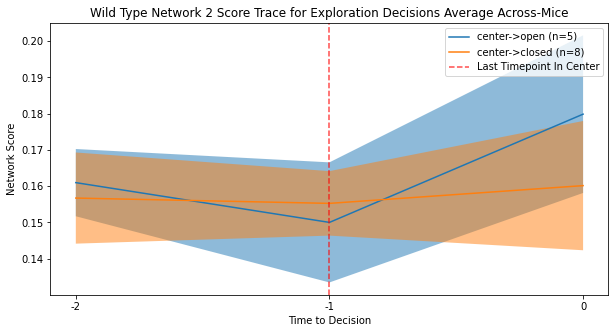

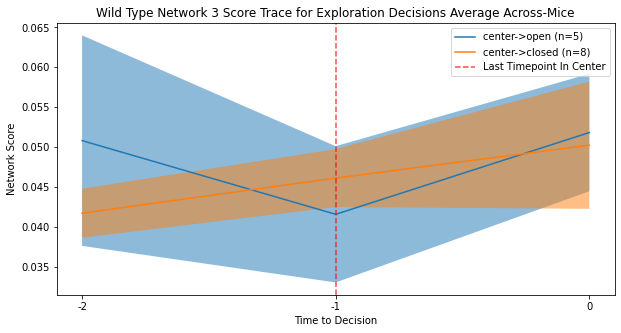

In [30]:
# Define window sizes before and after a specific point
n_windows_before = 2
n_windows_after = 1

# Initialize lists to store means and other data for different conditions and mice
wt_c2o_n1_mouse_means = []
wt_c2o_n2_mouse_means = []
wt_c2o_n3_mouse_means = []
wt_c2o_time_ids = []
wt_c2o_mouse_id = []
wt_c2o_n_segs = []

wt_c2cl_n1_mouse_means = []
wt_c2cl_n2_mouse_means = []
wt_c2cl_n3_mouse_means = []
wt_c2cl_time_ids = []
wt_c2cl_mouse_id = []
wt_c2cl_n_segs = []

# Iterate over unique mice in the dataframe
for mouse in np.unique(df_wt.mouse):

    # Create a mask for the current mouse
    mouse_mask = df_wt.mouse==mouse
    # Filter out NaN values in the ROI column
    nan_filter = df_wt.roi > 0
    mask = np.logical_and(mouse_mask,nan_filter)
    
    mouse_time = df_wt[mask==1]["time"].values
    task_start_time = np.min(mouse_time)
    task_end_time = task_start_time + 300
    time_mask = df_wt.time < task_end_time
    print(mouse,task_start_time,task_end_time)
    mask = np.logical_and(mask,time_mask)
    
    # Define masks for different conditions (CA, OA)
    oa_mask = np.logical_or(df_wt[mask==1]["roi"].values==2,
                            df_wt[mask==1]["roi"].values==4)

    ca_mask = np.logical_or(df_wt[mask==1]["roi"].values==1,
                            df_wt[mask==1]["roi"].values==3)
    
    # Extract relevant data for the current mouse and condition
    mouse_roi = df_wt[mask==1]["roi"].values
    mouse_time = df_wt[mask==1]["time"].values
    n1_s = df_wt[mask==1]["net 1 scores"].values
    n2_s = df_wt[mask==1]["net 2 scores"].values
    n3_s = df_wt[mask==1]["net 3 scores"].values
    
    # Initialize lists to store segment indexes for different conditions
    c2o_seg_idxs = []
    c2cl_seg_idxs = []

    # Iterate over ROI indexes and values
    for idx, roi in enumerate(mouse_roi):
        
        # Check if the current index is within the valid range
        if idx > n_windows_before and idx < (len(mouse_roi) - n_windows_after):
            
            # Get segment start and end points for CA to OA transition
            seg_start = idx - n_windows_before
            seg_end = idx + n_windows_after
            
            # Check for CA to OA transition conditions
            c2o_isTransition = oa_mask[idx]==1 and mouse_roi[idx-1]==5 and oa_mask[idx-2] == 0
            
            c2o_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2o_afterStable = np.sum(oa_mask[idx:seg_end])==n_windows_after
            c2o_isStable = np.logical_and(c2o_beforeStable,c2o_afterStable)
            
            c2o_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            
            if c2o_isTransition and c2o_isStable and c2o_isCont:
                c2o_seg_idxs.append((seg_start,seg_end))
                
            # Get segment start and end points for OA to CA transition
            c2cl_isTransition = mouse_roi[idx-1]==5 and oa_mask[idx-2]==0 and ca_mask[idx] == 1
            c2cl_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2cl_afterStable = np.sum(ca_mask[idx:seg_end])==n_windows_after
            c2cl_isStable = np.logical_and(c2cl_beforeStable,c2cl_afterStable)
            c2cl_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))

            if c2cl_isTransition and c2cl_isStable:
                c2cl_seg_idxs.append((seg_start,seg_end))
              
    # Save CA to OA segments if found
    if len(c2o_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2o_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2o_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        wt_c2o_n1_mouse_means.append(c2o_n1_segs_mean)
        wt_c2o_n2_mouse_means.append(c2o_n2_segs_mean)
        wt_c2o_n3_mouse_means.append(c2o_n3_segs_mean)
        wt_c2o_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2o_seg_idxs])
        wt_c2o_mouse_id.append(mouse)
        wt_c2o_n_segs.append(len(c2o_seg_idxs))
      
    # Save OA to CA segments if found
    if len(c2cl_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2cl_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        wt_c2cl_n1_mouse_means.append(c2cl_n1_segs_mean)
        wt_c2cl_n2_mouse_means.append(c2cl_n2_segs_mean)
        wt_c2cl_n3_mouse_means.append(c2cl_n3_segs_mean)
        wt_c2cl_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2cl_seg_idxs])
        wt_c2cl_mouse_id.append(mouse)
        wt_c2cl_n_segs.append(len(c2cl_seg_idxs))
    
# Convert lists to numpy arrays for easier manipulation
wt_c2o_n1_mouse_means = np.array(wt_c2o_n1_mouse_means)
wt_c2o_n2_mouse_means = np.array(wt_c2o_n2_mouse_means)
wt_c2o_n3_mouse_means = np.array(wt_c2o_n3_mouse_means)
wt_c2o_mouse_id = np.array(wt_c2o_mouse_id)
wt_c2o_time_ids = np.array(wt_c2o_time_ids,dtype=object)
wt_c2o_n_segs = np.array(wt_c2o_n_segs)

wt_c2cl_n1_mouse_means = np.array(wt_c2cl_n1_mouse_means)
wt_c2cl_n2_mouse_means = np.array(wt_c2cl_n2_mouse_means)
wt_c2cl_n3_mouse_means = np.array(wt_c2cl_n3_mouse_means)
wt_c2cl_mouse_id = np.array(wt_c2cl_mouse_id)
wt_c2cl_time_ids = np.array(wt_c2cl_time_ids,dtype=object)
wt_c2cl_n_segs = np.array(wt_c2cl_n_segs)

# Organize scores lists for CA to OA and OA to CA transitions
wt_c2o_scores_list = [wt_c2o_n1_mouse_means, wt_c2o_n2_mouse_means, wt_c2o_n3_mouse_means]
wt_c2cl_scores_list = [wt_c2cl_n1_mouse_means, wt_c2cl_n2_mouse_means, wt_c2cl_n3_mouse_means]

for net in range(3):
    
    mean = np.mean(wt_c2o_scores_list[net],axis=0)
    stderr = np.std(wt_c2o_scores_list[net],axis=0) / np.sqrt(wt_c2o_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="center->open (n={})".format(len(wt_c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(wt_c2cl_scores_list[net],axis=0)
    stderr = np.std(wt_c2cl_scores_list[net],axis=0) / np.sqrt(wt_c2cl_scores_list[net].shape[0])
    
    plt.plot(mean, label="center->closed (n={})".format(len(wt_c2cl_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Last Timepoint In Center")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Decision")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)

    plt.legend()
    plt.title("Wild Type Network {} Score Trace for Exploration Decisions Average Across-Mice".format(net+1))
    plt.show()

    clck_saveMat = np.hstack([wt_c2o_mouse_id.reshape(-1,1),
                             np.array(["wt" for _ in wt_c2o_mouse_id]).reshape(-1,1),
                            np.array(["center->open" for _ in wt_c2o_mouse_id]).reshape(-1,1),
                             np.array(wt_c2o_scores_list[net])]).astype(object)
    wt_saveMat = np.hstack([wt_c2cl_mouse_id.reshape(-1,1),
                           np.array(["wt" for _ in wt_c2cl_mouse_id]).reshape(-1,1),
                            np.array(["center->closed" for _ in wt_c2cl_mouse_id]).reshape(-1,1),
                           np.array(wt_c2cl_scores_list[net])]).astype(object)
    
    saveMat = np.vstack([clck_saveMat,wt_saveMat])
    temp_df = pd.DataFrame(saveMat,columns=["mouse","geno","decision","-2","-1","0"])
    temp_df.to_csv(PROJECT_PATH + "WT_center_to_open_vs_center_to_closed_net_{}.csv".format(net))

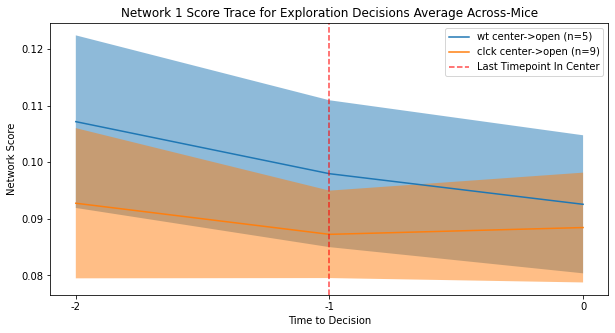

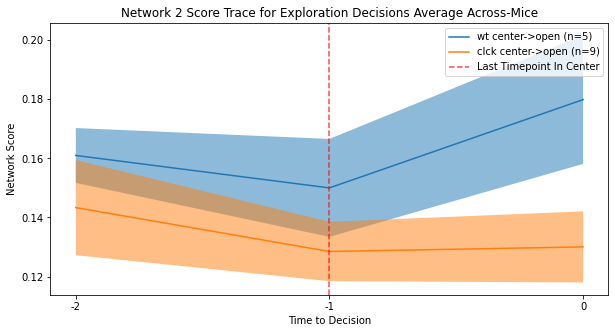

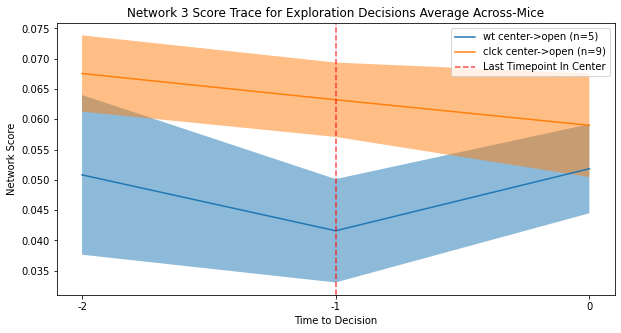

In [33]:
for net in range(3):
    
    mean = np.mean(wt_c2o_scores_list[net],axis=0)
    stderr = np.std(wt_c2o_scores_list[net],axis=0) / np.sqrt(wt_c2o_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="wt center->open (n={})".format(len(wt_c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(clck_c2o_scores_list[net],axis=0)
    stderr = np.std(clck_c2o_scores_list[net],axis=0) / np.sqrt(clck_c2o_scores_list[net].shape[0])

    plt.plot(mean, label="clck center->open (n={})".format(len(clck_c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Last Timepoint In Center")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Decision")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)

    plt.legend()
    plt.title("Network {} Score Trace for Exploration Decisions Average Across-Mice".format(net+1))
    plt.show()
    
    clck_saveMat = np.hstack([clck_c2o_mouse_id.reshape(-1,1),
                             np.array(["clck" for _ in clck_c2o_mouse_id]).reshape(-1,1),
                            np.array(["center->open" for _ in clck_c2o_mouse_id]).reshape(-1,1),
                             np.array(clck_c2o_scores_list[net])]).astype(object)
    wt_saveMat = np.hstack([wt_c2o_mouse_id.reshape(-1,1),
                           np.array(["wt" for _ in wt_c2o_mouse_id]).reshape(-1,1),
                            np.array(["center->open" for _ in wt_c2o_mouse_id]).reshape(-1,1),
                           np.array(wt_c2o_scores_list[net])]).astype(object)
    
    saveMat = np.vstack([clck_saveMat,wt_saveMat])
    temp_df = pd.DataFrame(saveMat,columns=["mouse","geno","decision","-2","-1","0"])
    temp_df.to_csv(PROJECT_PATH + "CLCK_vs_WT_center_to_open_net_{}.csv".format(net))

In [32]:
wt_c2o_mouse_id

array(['Mouse0914', 'Mouse2402', 'Mouse2403', 'Mouse30391', 'Mouse30392'],
      dtype='<U10')

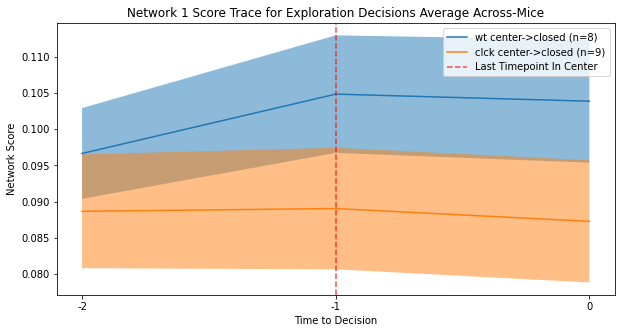

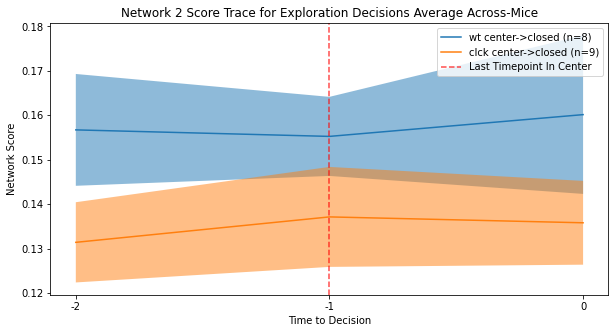

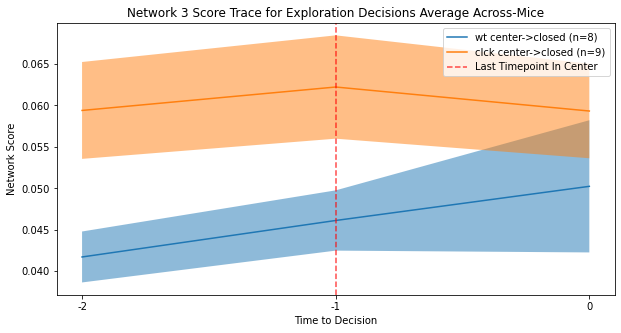

In [6]:
for net in range(3):
    
    mean = np.mean(wt_c2cl_scores_list[net],axis=0)
    stderr = np.std(wt_c2cl_scores_list[net],axis=0) / np.sqrt(wt_c2cl_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="wt center->closed (n={})".format(len(wt_c2cl_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(clck_c2cl_scores_list[net],axis=0)
    stderr = np.std(clck_c2cl_scores_list[net],axis=0) / np.sqrt(clck_c2cl_scores_list[net].shape[0])

    plt.plot(mean, label="clck center->closed (n={})".format(len(clck_c2cl_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Last Timepoint In Center")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Decision")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)

    plt.legend()
    plt.title("Network {} Score Trace for Exploration Decisions Average Across-Mice".format(net+1))
    plt.show()